# Linear Regression with Gradient Descent

---

*You can watch a [video](https://youtu.be/-cs5D91eBLE) of this lesson, if you prefer.*

---

Gradient descent is a technique that helps us set the correct weights and biases as neural network parameters.<br>
Without gradient descent, state-of-the-art networks wouldn't be able to learn how to make predictions from data.

In this notebook, we'll learn about gradient descent by using it to train a linear regression model.

Linear regression is a popular supervised machine learning algorithm that predicts a target given some input variables, called predictors.<br>
We'll use linear regression to predict tomorrow's temperature using historical data.

Let's start by reading in the data first:

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read in the data
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
# Fill NA/NaN values by pasting the last valid observation
data = data.ffill()

# Show the first 5 rows of the data
data.head(5)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


## Linear Regression Intuition

Each row in our dataset describes a different day.<br>
The columns are different weather observations associated with that day.<br>
We have data from $1970$ to $2022$.

Using the data above, we could predict `tmax_tomorrow` based on:
- Today's max temperature (`tmax`),
- Today's min temperature (`tmin`), and/or 
- How much it rained today (`rain`).

> Linear regression requires a linear relationship between the predictors and the target.<br>
> If two values have a linear relationship, when one value changes, the other value changes too, in some proportion.

We can visualize this for `tmax` and `tmax_tomorrow` with a scatter plot:

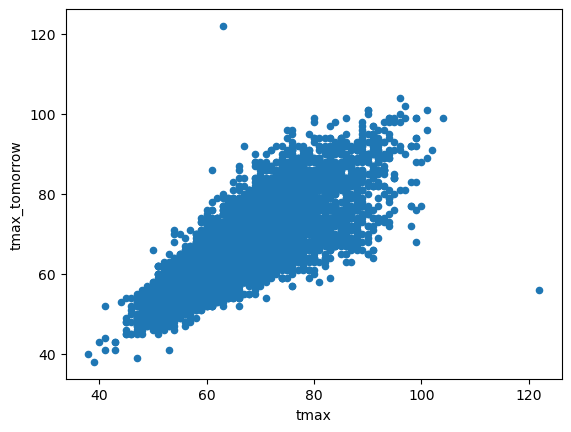

In [3]:
data.plot.scatter("tmax", "tmax_tomorrow");

As you can see, `tmax` and `tmax_tomorrow` correlate pretty linearly.<br>
When `tmax` increases, `tmax_tomorrow` usually does as well.<br>
Intuitively, if we drew a line through the center of the point cloud, we could use the line as a guide to predict `tmax_tomorrow` from `tmax`.<br>
Since `tmax` can be viewed as linearly related to `tmax_tomorrow`, the line will tell us what amount to scale and shift `tmax` by in order to get a prediction for `tmax_tomorrow`.

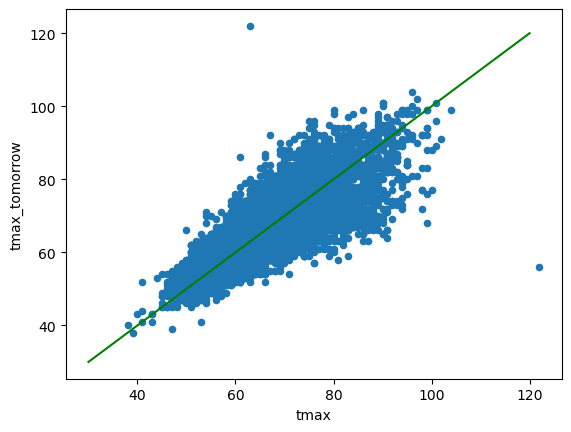

In [4]:
data.plot.scatter("tmax", "tmax_tomorrow")

# Just plotting in an example line here
plt.plot([30,120], [30,120], 'green');

The data points are in blue, and the good looking but arbitrarily chosen regression line is in green.<br>
In our example, the green line is scaling `tmax` by $1$ and shifting it by $0$ to provide a 'prediction' for `tmax_tomorrow`.<br>
Put differently, the example regression line is expressed as $\ \hat{tmax_{tomorrow}} = 1 \cdot tmax + 0$.<br>
It is of the general form $\hat{y}=wx+b$ which is the one thing our example has in common with the actually correctly calculated line.

Let's see how we can replace our arbitrary line with a line that is *actually* calculated using gradient descent.

## Linear Regression Equation

> Linear regression aims to find the best choice for $w$ and $b$ so as to minimize the difference between the predicted $\hat{y}$ and the actual $y$ perceived from the data.

The equation for prediction with three predictors looks like this:
$$\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$$

- $\hat{y}$ is our prediction for `tmax_tomorrow`,
- $x_n$ are the predictors that we're utilizing to predict $\hat{y}$ (here it's `tmax`, `tmin`, and `rain`),
- $w_n$ are the weight parameters that the linear regression algorithm will learn,
- $b$ is the bias (or $y$-intercept); This enables us to "shift" the prediction line up or down to further match the data.

To simplify things, for now, we will go into detail with just a single predictor: `tmax`.

Let's take a look at how a simple linear regression model works:

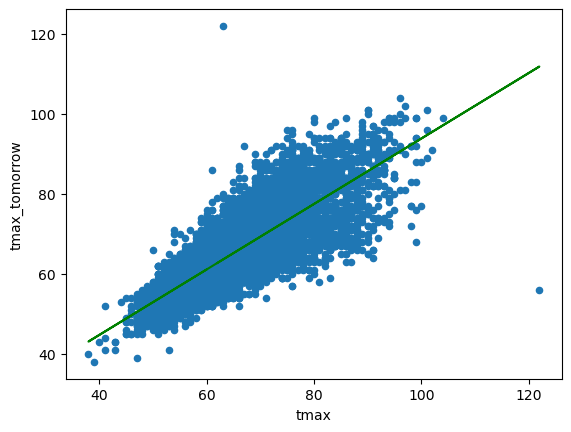

In [5]:
# We use SciKit Learn's Linear Regression model
lr = LinearRegression()

# We aim to find w and b that best describe the relationship between tmax and tmax_tomorrow
# through tmax_tomorrow = w * tmax + b
# SciKit Learn will find the best w and b for us with the .fit() method
lr.fit(data[["tmax"]], data["tmax_tomorrow"])

# Plot our data points and the regression line
data.plot.scatter("tmax", "tmax_tomorrow")

# Predicting the value of tmax_tomorrow for each tmax forms a green line
plt.plot(data["tmax"], lr.predict(data[["tmax"]]), color="green");

We just fitted a linear regression model using a library called `SciKit-Learn`.<br>
`SciKit-Learn` pretty much just did all the work for us, but we will use its result as a reference<br>
for when we implement our own linear regression model.<br>

We can take a look at the coefficients for the line $\hat{y}=wx+b$ that `SciKit-Learn` came up with below:

In [6]:
print(f"Weight: {lr.coef_[0]:.2f}")
print(f"Bias: {lr.intercept_:.2f}")

Weight: 0.82
Bias: 11.99


Predictions for `tmax_tomorrow` are be formulated through $\hat{y}=.82 \cdot \text{tmax} + 11.99$.<br>
Again, this is what things ought to look like. We now have a reference result for our own implementation.

Now let's see how to implement our own linear regression from the ground up.

## Calculating Loss

Earlier, I mentioned that we'd train our linear regression algorithm *using gradient descent*.<br>
To make gradient descent work, we first need to **calculate a loss**.

If we have a loss, i.e. a measure of difference between expectation and prediction,<br>
we can see the degree to which our predictions are off and adjust our parameters in a measured way.

> The loss will guide us in how to adjust our parameters to make better predictions.

Luckily, our dataset allows for just that. Per each day/row, we have the actual `tmax_tomorrow`<br>
to compare against the `tmax_tomorrow` we predicted from just `tmax`.<br>

Let's say today's `tmax` is $80$. Using the linear equation, we can calculate `tmax_tomorrow` to be $77.59$.<br>
Then we can calculate our loss by comparing to `tmax_tomorrow`.<br>
With linear regression it's common to use what's called a **squared error**:
$$L = \text{MSE}=\frac{1}{N}\sum_{i=1}^{N}(\hat{y_i} - y_i) ^ 2$$

If the actual `tmax_tomorrow` is $81$, then our loss is $(77.59 - 81) ^ 2 = 11.63$.<br>
We're concerned with just this one loss, so for the above equation $N$ is $1$.

Our parameters (weight $w$ and bias $b$) caused this loss value.<br>
If we change $w$ or $b$, our loss will also change.

Let's visualize what it would look like if our weight value was $1$:

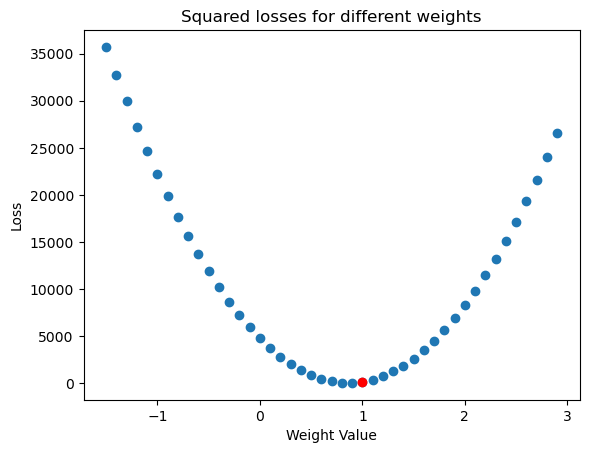

In [7]:
x = 80
y = 81
b = 11.99 # Recycled from the SciKit Learn run above

# Function to calculate the loss, leave x, b and y constant
loss = lambda w: ((w * x + b) - y) ** 2

# Calculate losses for several weight configurations
ws = np.arange(-1.5,3,.1)
losses = loss(ws)

# Setup the plot
plt.xlabel("Weight Value")
plt.ylabel("Loss")
plt.title("Squared losses for different weights")

# Plot weights and respective losses
plt.scatter(ws, losses)

# Plot weight of 1 and corresponding loss in red
plt.plot(1, loss(1), 'ro');

We've graphed the weights on the $x$-axis, and the corresponding losses on the $y$-axis.<br>
There is a value at the very bottom of the graph where loss is the lowest.<br>
It's not the red dot, but even lower than that.<br>
Loss increases if the weight is higher or lower than that specific value.<br>
This is called the **global minimum**, and it's our goal to determine and reach this value for $w$.

We've marked our weight value of $1$ in red. It's close to the global minimum, but not quite there.<br>
This is where gradient descent comes into play - it helps adjusting our parameters to reduce loss.

First, we calculate the loss when the weight is (randomly set to) $1$.<br>
This equals $((1 \cdot 80 + 11.99) - 81) ^ 2 = 120.78$.<br>

We now have to figure out *how much* each parameter's value contributes to this loss.

## Parameter Updates

To understand how we find the contribution of each parameter,<br>
let's first take a look at the operations we perform to get a prediction. 

This is called a computational graph:
<div style="text-align:center;">
    <img src="../images/linreg/gradient.svg" alt="Operations">
</div>

We take our input data (`tmax`), multiply it by the weight $w$, add the bias $b$ and get our prediction.

To make the prediction get closer to the correct value, we need to adjust $w$ and $b$.<br>
We need to know how much to adjust them, and in which direction (positive or negative).

To figure this out, we take what's called the partial derivative of the loss against $w$ and $b$, respectively.  This is a math way of saying "we're going to figure out how much each parameter contributes to our loss".

We start by calculating the gradient of our loss itself.<br>
The gradient tells us the direction and magnitude of the steepest increase of our loss. We want to move in the exact opposite direction, i.e. where loss is decreasing the fastest. We can calculate the gradient by taking the derivative of our loss metric, which is:
$$\partial L = 2 \cdot (\hat{y} - y) = 2 \cdot ((wx+b)-y)$$
This shows us how quickly our loss is changing:

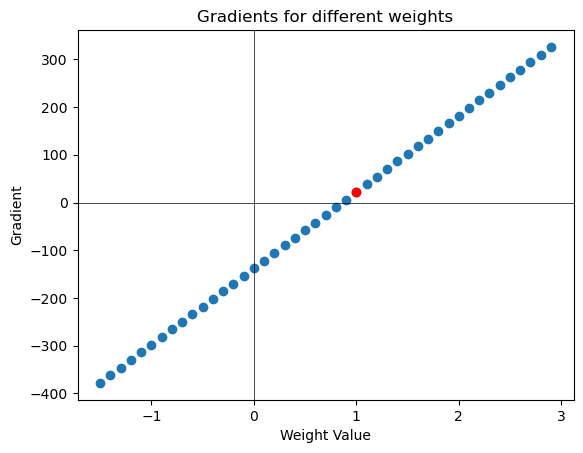

In [8]:
x = 80
y = 81
b = 11.99 # Recycled from the SciKit Learn run above

# Function to calculate the gradient
gradient = lambda w: ((w*x+b)-y) * 2
woi = 1 # Weight of interest

# Calculate gradient values for several weights
gradients = gradient(ws)

# Plot the weight and gradients
plt.scatter(ws, gradients)

# Plot origin lines
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

# Title and Labels
plt.title("Gradients for different weights")
plt.xlabel("Weight Value")
plt.ylabel("Gradient")

plt.plot(woi, gradient(woi), 'ro');

If our weight is above around $.82$, our gradient is positive. If our gradient is positive, the direction in which we want to change is negative. This means, from $.82$ onwards, our predictions $\hat{y}$ become too large.

If $w$ is below the value, then our gradient is negative, the direction in which we would want to go would hence be positive. Our predictions $\hat{y}$ are too small.

Our gradient at $w=1$ is $2 \cdot ((1 \cdot 80 + 11.99) - 81) = 21.98$, seen in red.

Our goal is to get to a place where the gradient is close to `0`.<br>
At this point, our predictions would match the actual values and no changes would be required to $w$ and $b$.<br>
Hopefully this area will be the global minimum. Sometimes it will be a local minimum.

We'll discuss this case later.

### The Partial Derivative

#### Partial Derivative of Bias

The partial derivative with respect to the loss gradient tells us ow much to adjust each parameter to maximize the loss. Negating that, it tells us how much to adjust each parameter to minimize it.<br>
First, let's take the partial derivative with respect to $b$:

$$\frac{\partial L}{\partial b} = \partial L = 2 \cdot ((wx+b)-y)$$

Because you add $b$ to $(x \cdot w)$ to get $\hat{y}$, any change of $b$ directly affects the prediction.<br>
Therefore, the partial derivative of $b$ with respect to the loss $L$ is the same as the loss gradient $\partial L$.

<div style="text-align:center;">
    <img src="../images/linreg/b_deriv.svg" alt="B Derivative">
</div>

#### Partial Derivative of Weight

Next, we take the partial derivative with respect to $w$.<br>
This is more complicated, since we multiply $w$ by $x$, then add it to $b$ to get our prediction.<br>
We use the chain rule to find the derivative. The chain rule says that the partial derivative<br>
of $q$ with respect to $s$ equals the partial derivative of $q$ with respect to $r$ times<br>
the partial derivative of $r$ with respect to $s$.

Chain rule definition:
$$\frac{\partial q}{\partial s} = \frac{\partial q}{\partial r} \cdot \frac{\partial r}{\partial s}$$

Applying the chain rule yields:
$$\frac{\partial L}{\partial w}=\frac{\partial L}{\partial (x\cdot w)} \cdot \frac{\partial (x\cdot w)}{\partial w}$$

Similar to what we saw with bias $b$, $\frac{\partial L}{\partial (x\cdot w)}$ is<br>
just the same as $\partial L$, since we, like $b$, additively apply $(x*w)$ to get the loss.<br>
So we can update the equation to:
$$\frac{\partial L}{\partial w}=\partial L \cdot \frac{\partial (x\cdot w)}{\partial w}$$

Since we multiply $w$ by $x$, any change to $w$ will change the prediction proportional to $x$.<br>
Therefore:
$$\frac{\partial (x\cdot w)}{\partial w} = x$$

Putting it all together, we find:
$$\frac{\partial L}{\partial w} = \partial L \cdot x = 2 \cdot ((wx+b)-y) \cdot x$$

<div style="text-align:center;">
    <img src="../images/linreg/w_deriv.svg" alt="W Derivative">
</div>

After calculating the partial derivatives, we update $w$ and $b$ by **subtracting the partial derivatives** from the current values. We don't want to subtract the entire partial derivative, though.

If the partial derivative would get applied as-is, we might know the direction of steepest descent from that, but the magnitude would be specific to the current data point.

Old Loss: 120.78
New Loss: 19785519734.22


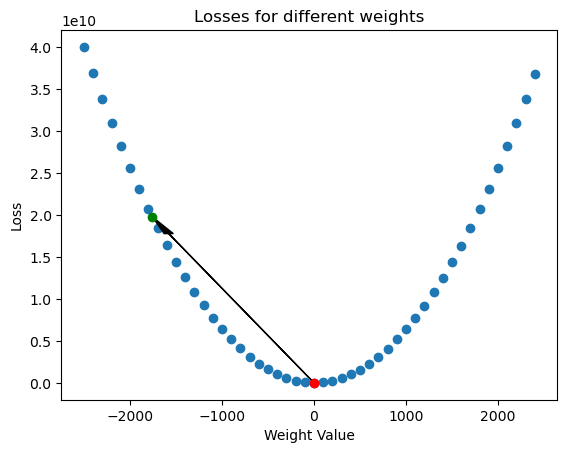

In [9]:
x = 80
y = 81
b = 11.99 # Recycled from the SciKit Learn run above

ws = np.arange(-2500, 2500, 100)
woi = 1 # Weight of interest

gradient = lambda w: ((w * x + b) - y) * 2 * x
loss = lambda w: ((w * x + b) - y) ** 2

losses = loss(ws)

# Plot the weight and losses
plt.scatter(ws, losses)

# Show Original weight
plt.plot(woi, loss(woi), 'ro')

# New weight
new_weight = woi - gradient(woi)
plt.plot(new_weight, loss(new_weight), 'go');
plt.arrow(woi, loss(woi), new_weight, loss(new_weight), head_width=100, head_length=2e9, length_includes_head=True, color='black');

plt.title("Losses for different weights")
plt.xlabel("Weight Value")
plt.ylabel("Loss")

print(f'Old Loss: {loss(woi):.2f}')
print(f'New Loss: {loss(new_weight):.2f}')

You can see the original weight in red, and the new weight in green. Notice how the error actually gets higher with the new weight. This is because we took too large of a step in applying the full negative gradient.

## Learning Rate

The above graph shows a common problem with gradient descent:<br>
We adjust our parameters so harshly that we overshoot the minimum and end up in an even worse place.

> Overshooting happens because the partial derivative doesn't know that the gradient will change across the space of possible weight values.

Since we're taking the derivative at a single point, it assumes that the gradient will stay constant. But instead, as we can see in the chart below, the gradient changes between the old weight and the new weight. Even worse, the gradient is changed to be further away from $0$:

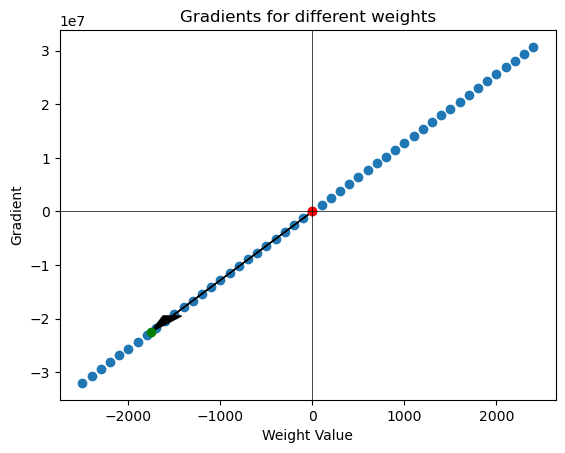

In [10]:
# Calculate gradient values for several weights
gradients = gradient(ws)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1), 'ro')

# Plot origin
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

plt.title("Gradients for different weights")
plt.xlabel("Weight Value")
plt.ylabel("Gradient")

# New weight
plt.arrow(1, gradient(1), new_weight, gradient(new_weight), head_width=200, head_length=3e6, length_includes_head=True, color='black')
plt.plot(new_weight, gradient(new_weight), 'go');

To adjust for this, we use scale to the gradient. This is the learning rate.<br>
This scaling of the partial derivative enables us to take a smaller step in the right direction, while staying within a parameter region where the respective gradient wouldn't deviate too much from ours:

Old Weight: 1.00
New Weight: 0.91

Old Loss: 120.78
New Loss: 15.65

Old Gradient: 1758.40
New Gradient: 633.02


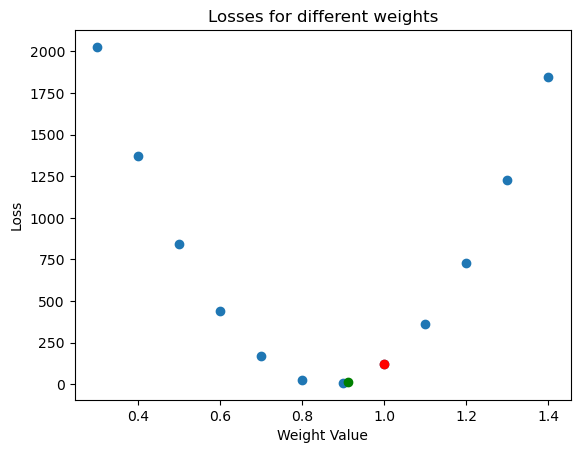

In [11]:
x = 80
y = 81
b = 11.99
ws = np.arange(.3, 1.5, .1)
woi = 1 # Weight of interest

gradient = lambda w: ((w*x+b)-y) * 2 * x
loss = lambda w: ((w * x + b) - y) ** 2

losses = loss(ws)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(woi, loss(woi), 'ro')

plt.title("Losses for different weights")
plt.xlabel("Weight Value")
plt.ylabel("Loss")

# New weight with learning rate
lr = 5e-5
new_weight = woi - lr * gradient(woi)
plt.plot(new_weight, loss(new_weight), 'go');

print(f'Old Weight: {woi:.2f}')
print(f'New Weight: {new_weight:.2f}\n')

print(f'Old Loss: {loss(woi):.2f}')
print(f'New Loss: {loss(new_weight):.2f}\n')

print(f'Old Gradient: {gradient(woi):.2f}')
print(f'New Gradient: {gradient(new_weight):.2f}')

The new weight is $\approx .91$, and has considerably lower error than the original weight of $1$.<br>
Note that the gradient with the new weight is very different from the gradient with the original weight.<br>
With a weight of $1$, it was $1758.4$, but it is now $633.02$.<br>
It's still not $0$, so we're not at a minimum.

To get to the minimum, we just repeat gradient descent multiple times to<br>
further "descend" towards the correct weight and bias values. 

The methodic loop looks like this:

- Predict $y$ using the current parameters $w$ and $b$
- Measure the gradients of the loss with respect to $w$ and $b$
- Update $w$ and $b$ using the scaled partial derivatives
    - $\frac{\partial L}{\partial b} = 2 \cdot ((wx+b)-y)$
    - $\frac{\partial L}{\partial w} = 2 \cdot ((wx+b)-y) \cdot x$

We repeat until convergence, i.e. until a minimum is reached, which has a gradient sufficiently close to $0$.

Of course, in linear regression, we're looking at hundreds or thousands of rows, not just a single data point.<br>
In this case, we loop through the entire data set, and calculate a gradient for each row.<br>
We then average them and use the average gradient to update our parameters.<br>
This is repeated until this gradient averaged over the entire training set becomes sufficiently close to $0$.

Theory done!<br>
We now know everything we need to get started fully implementing linear regression with gradient descent!

## Implementation

Let's first load our data and split it into 3 sets:

- A **training set**, which we'll use to train our algorithm
- A **validation set**, which we'll use to measure error during training
- A **test set**, which we'll use to evaluate the model after it has been fit

We use the training set to ... train. The validation set then helps us to see how well our model generalizes to new data.<br>
The test set is then ultimately used to evaluate the model's performance.

In [12]:
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Ensure Reproducibility
np.random.seed(0)

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] 
                                                            for d in split_data]

To train a linear regression algorithm with $3$ predictors using gradient descent, we need $4$ elements:

- A way to initialize our parameters (weights and biases)
- A `forward pass` that computes predictions using the parameters
- A `loss function` that measures the error of our predictions
- A `backward pass` that updates our parameters to reduce the loss

To initialize our weight parameters, we can just use random initialization.<br>
Random initialization helps the gradient descent algorithm to descend to a global minimum more efficiently<br>
(feel free to experiment with other initializations, like $0$ or $1$ to see what happens)<br>
(There are different initialization methods beyond random initialization. See [here](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/) for more details.)

We'll choose small initial parameter values so that we don't end up with predictions that are too extreme.

In [13]:
def init_params(predictors: int, targets: int) -> list:
    # predictors: Number of predictors
    k = math.sqrt(1 / predictors) # Scaling factor, reduces w and b initially
    np.random.seed(0) # Ensure Reproducibility
    weights = np.random.rand(predictors, 1) * 2 * k - k
    biases = np.ones((targets, 1)) * 2 * k - k
    return  [weights, biases]

We initialize one $w$ value per each predictor (`tmax`, `tmin`, and `rain`).<br>
We initialize one $b$ value per each target variable (`tmax_tomorrow`).

In the `forward pass` of our network, we generate predictions by multiplying $w$ and $x$ and then adding $b$:

In [14]:
def forward(params: list, x: np.ndarray) -> np.ndarray:
    weights, biases = params
    return x @ weights + biases

Once we have predictions, we need to calculate the error, i.e. the loss $L$.<br>
We have two functions:
- One function to calculate the loss, and 
- One function to calculate the loss gradient (which helps us update our parameters)

These are the two functions in question:

In [15]:
def mse(actual: np.float32, predicted: np.float32) -> np.float32:
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual: np.float32, predicted: np.float32) -> np.float32:
    return predicted - actual

In the `backward pass` of the network, we now adjust the parameters $w$ and $b$ by the partial derivative times the learning rate.<br>
We will make predictions for our entire training set, then average the gradient across the whole set to ultimately determine the updates.<br>
This will ensure that a single training example doesn't pull the gradient too far in one direction or another.

In [16]:
def backward(params: list, x: np.ndarray, lr: np.ndarray, grad: np.ndarray) -> list:
    # Multiply the loss gradient by scaled x values
    w_grad = (x.T / x.shape[0]) @ grad # Dividing x by row count in x to avoid too large updates
    b_grad = np.mean(grad, axis=0)

    params[0] -= w_grad * lr # Weights
    params[1] -= b_grad * lr # Bias

    return params

Finally, we'll write the training loop that:

- Makes predictions for the whole training set,
- Computes the gradient for each training example,
- Updates the parameters based on the gradient

We will run the algorithm for several epochs.

> An epoch is a full iteration over the training set.

Up to a point, more epochs will improve the accuracy.<br>
We will print the loss on the validation set regularly so we can monitor it.<br>
We know we have too many epochs if the validation loss is increasing instead of decreasing, because we start overfitting.

In [17]:
lr = 1e-4
epochs = 50000
params = init_params(predictors=train_x.shape[1], targets=1)

# Store weights and gradients so we can visualize
# Not necessary for training itself
sample_rate = 100
samples = int(epochs / sample_rate)
historical_ws = np.zeros((samples, train_x.shape[1]))
historical_gradient = np.zeros((samples,))

# Training Loop
for i in range(epochs):
    predictions = forward(params=params, x=train_x)
    grad = mse_grad(actual=train_y, predicted=predictions)
    params = backward(params=params, x=train_x, lr=lr, grad=grad)

    # Store weights for historical visualization
    # Not necessary for training itself
    if i % sample_rate == 0:
        index = int(i / sample_rate)
        historical_gradient[index] = np.mean(grad)
        historical_ws[index,:] = params[0][:,0]

    # Display validation loss
    if i % 10000 == 0 or i == epochs - 1:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)
        print(f"Epoch {i} - Validation loss: {valid_loss:.3f}")

Epoch 0 - Validation loss: 297.275
Epoch 10000 - Validation loss: 22.647
Epoch 20000 - Validation loss: 22.614
Epoch 30000 - Validation loss: 22.581
Epoch 40000 - Validation loss: 22.549
Epoch 49999 - Validation loss: 22.518


We can display our final parameters to see how the regression worked.  This will show the weight for each predictor, as well as the bias:

In [18]:
print(f'tmax_tomorrow = {params[0][0]} * tmax + {params[0][1]} * tmin + {params[0][2]} * rain + {params[1][0]}')

tmax_tomorrow = [0.79210427] * tmax + [0.2450347] * tmin + [-0.06038591] * rain + [1.12700385]


We can also visualize the path of gradient descent.<br>
We're limited to three dimensions, but we can look at $w_{1}$ (the weight for `tmax`) and $w_{2}$ (the weight for `tmin`) in relation to the gradient. We can see that we started in an area of strongly negative gradient, where our predictions were considerably lower than the actual temperatures. This happened because $w_{1}$ and $w_{2}$ were initialized to random values. Both parameters then moved towards a minimum over many epochs, as we tried to move to an area of `0` gradient.

This is what that process looks like:

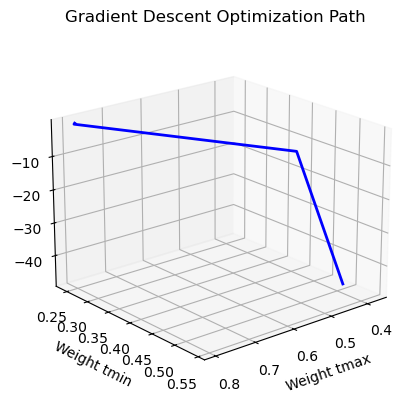

In [19]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 50)

# Descriptions
ax.set_xlabel("Weight tmax")
ax.set_ylabel("Weight tmin")
ax.set_title("Gradient Descent Optimization Path")

# Plot the path of the optimization algorithm
ax.plot3D(historical_ws[:,0], historical_ws[:,1], historical_gradient, 'blue', linewidth=2, zorder=10)

plt.show();

We can also evaluate the algorithm on the test set to measure error:

In [20]:
predictions = forward(params, test_x)
print(f'MSE Test Error: {mse(test_y, predictions)}')

print(test_y.shape)
print(predictions.shape)

MSE Test Error: 23.33521456477465
(2027, 1)
(2027, 1)


Let's now actually apply the model to some data. We'll plot the predictions in red, and the actual values in blue:

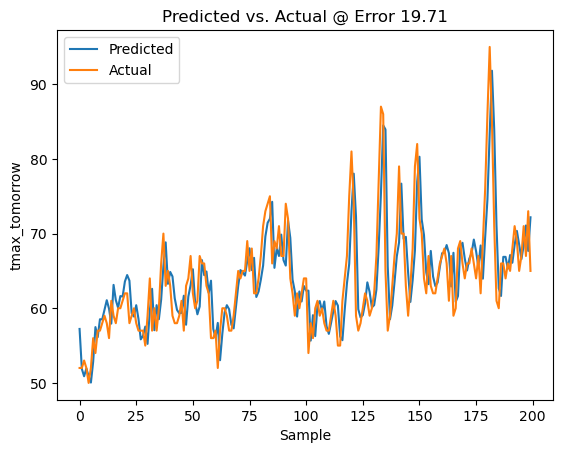

In [22]:
# Get 10 random entries from data pandas frame
sample_set = data.head(200)
predictions = forward(params, sample_set[PREDICTORS].to_numpy())

# Plot the predictions against the actual values as points
plt.plot(predictions, label="Predicted")
plt.plot(sample_set[TARGET].to_numpy(), label="Actual")
plt.legend()

sample_error = mse(sample_set[TARGET].to_numpy().reshape(-1,1), predictions)

# Descriptions
plt.title(f"Predicted vs. Actual @ Error {sample_error:.2f}")
plt.xlabel("Sample")
plt.ylabel("tmax_tomorrow")

plt.show();

Well done! You just worked through a full implementation of linear regression with gradient descent.

In practice, the interactions between neural network layers will be complex enough<br>
that you will likely not attain a global minimum.

If the error is higher than you expect, you can try changing the learning rate<br>
(lowering it will take longer to converge, but may be more likely to reach a global minimum).

You can also try re-initializing the layer weights and retrying gradient descent.<br>
It is not a huge issue if you reach a local minimum instead of a global minimum,<br>
as long as your error is good enough for your application.

Also, finding a global minimum in sufficiently complex networks is NP-hard, so if you have a solution, hit me up.<br>
You should now understand how gradient descent works to update parameters.

In this next notebook, we'll cover how to train a dense neural network using gradient descent!